<a href="https://colab.research.google.com/github/Nima-Nilchian/Keyword_extraction/blob/master/Keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keyword Extraction

# استخراج عبارت‌های کلیدی متن

<p align="right">
ارزیابی روش‌ها مورد استفاده قرار خواهد گرفت. علاوه بر گزارش نتایج برای هر یک از روش‌ها با استفاده از مجموعه داده، نمونه‌هایی از خروجی را هم برای هر روش گزارش کرده و به صورت شهودی نیز مقایسه‌ای انجام دهید. همچنین سرعت روش‌های پیاده‌سازی شده نیز نیاز به مقایسه دارد.
</p>
<p align="right">
:روش‌های زیر را پیاده‌سازی و طبق روال بالا ارزیابی و مقایسه کنید
</p>

*   baseline (TF-IDF)
*   TF-IDF with Ngrams
*   TF-IDF with chunking
*   KP-Miner
*   Yake
*   TextRank
*   SingleRank
*   TopicRank
*   TopicalPageRank
*   PositionRank
*   MultipartiteRank
*   scake
*   sgrank











# Reading and preproccessing Data

In [ ]:
!pip install git+https://github.com/boudinfl/pke.git
!pip install perke
!python -m perke download
!pip install yake

  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-i_r2bro6
  Running command git clone --filter=blob:none --quiet https://github.com/boudinfl/pke.git /tmp/pip-req-build-i_r2bro6
  Resolved https://github.com/boudinfl/pke.git to commit 69871ffdb720b83df23684fea53ec8776fd87e63
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 2.2 MB/s eta 0:00:00
  Created wheel for pke: filename=pke-2.0.0-py3-none-any.whl size=6160630 sha256=ab7a18b5fe6f7dd777038d4e328dc9fc312486304bbc337c63a197f9ec1a8434
  Stored in directory: /tmp/pip-ephem-wheel-cache-rixm76vs/wheels/8c/07/29/6b35bed2aa36e33d77ff3677eb716965ece4d2e56639ad0aab
Successfully built pke
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.5/367.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.

Downloading...
From: https://drive.google.com/uc?id=1Q3JK4NVUC2t5QT63aDiVrCRBV225E_B3
To: /usr/local/lib/python3.10/dist-packages/perke/resources/pos_tagger.model
100% 19.2M/19.2M [00:00<00:00, 111MB/s] 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.7 MB/s eta 0:00:00


In [256]:
import numpy as np
import pandas as pd
import json
import string
import perke
import time
import multiprocessing
import matplotlib.pyplot as plt

import yake
import re

In [ ]:
from google.colab import drive
drive.mount("./content")

Mounted at ./content


In [ ]:
data_loc = './content/MyDrive/datasets/ke/ke_dataset.txt'

df = pd.DataFrame()
with open(data_loc, 'r') as f:
  for line in f.readlines():
    json_data = json.loads(line.strip())
    df = pd.concat([df, pd.DataFrame([json_data])], ignore_index=True)

df.drop('id', axis=1, inplace=True)
all_texts = df['body'].tolist()

In [218]:
df

,body,keywords,existing_keywords
0,این نوشتار بر آن است تا با بررسی فقه الحدیثی ک...,"[فقه الحدیث, معانی الاخبار, روش فقه الحدیثی, چ...","[فقه الحدیث, معانی الاخبار, روش فقه الحدیثی, چ..."
1,چکیده: این پژوهش براساس چارچوب نظری ...,"[سید محمد خاتمی, آدریان لفت ویچ, پیتر ایوانز, ...","[سید محمد خاتمی, آدریان لفت ویچ, پیتر ایوانز, ..."
2,فهم معانی عمیق و تدبر در آیات قرآن کریم برای ب...,"[جایگاه آرائ تفسیری, محمد یزدی, ترجمه قرآن]","[محمد یزدی, ترجمه قرآن]"
3,آزادی موهبتی است الهی که خدای متعال به انسان ع...,"[محدودیت بازدارنده, آزادی بیان, بدعت, دین, ارت...","[آزادی بیان, بدعت, دین, ارتداد, کتب ضلال, اهان..."
4,یکی از نکاتی که توجه پژوهشگران اندیشه‌های سیاس...,"[آزادی, محمد تقی مصباح یزدی, مرتضی مطهری, دموک...","[آزادی, مرتضی مطهری, دموکراسی, تفسیر دین, اندی..."
...,...,...,...
445,پژوهش حاضر با هدف بررسی رابطه رضایت شغلی با تع...,"[شیراز, ارزیابی عمل‌کرد, کارکنان, عمل‌کرد شغل,...","[شیراز, کارکنان, تعهد سازمانی, رضایت شغلی]"
446,سازمان ملل متحد در دهه های اخیر، با تغییر ساخت...,"[کمیسیون حقوق‌بشر, حقوق‌بشر در ایران, بررسی دو...",[]
447,تفسیرهای فقهی از قدیمی‌ترین تفاسیری هستند که ا...,"[استنباط, کنز العرفان, آیات الاحکام, قواعد تفس...","[استنباط, کنز العرفان, آیات الاحکام, قواعد تفس..."
448,هدف از انجام این تحقیق بررسی تاثیر کیفیت زندگی...,"[مدل GSTARS 2.1, نوع دوستی, رفتار شهروندی سازم...","[نوع دوستی, رفتار شهروندی سازمانی, تواضع, کیفی..."


In [168]:
exist_keywords = []
c = 0
for i in range(len(df)):
  keywords = [k for k in df.keywords.iloc[i] if k in df.body.iloc[i]]
  exist_keywords.append(keywords)

# df['existing_keywords'] = exist_keywords

In [281]:
def evaluate(candidates, references):
    if len(references) == 0:
      return 0.5

    r = len(set(references) & set(candidates)) / len(set(references))
    p = len(set(references) & set(candidates)) / len(set(candidates))

    if p == 0 or r == 0:
      return [0, 0, 0]

    return [(2*p*r) / (p+r), r, p]

In [104]:
def ke_topicRank(text):
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.TopicRank()

  extractor.load_text(input=text, word_normalization_method=None)
  extractor.select_candidates()
  extractor.weight_candidates(
      threshold=0.67, metric='jaccard', linkage_method='average')

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)


def ke_textRank(text):
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.TextRank()

  extractor.load_text(text, word_normalization_method=None)
  extractor.weight_candidates(window_size=3, top_t_percent=0.33)

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)


def ke_singleRank(text):
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.SingleRank()

  extractor.load_text(input=text, word_normalization_method=None)
  extractor.select_candidates()
  extractor.weight_candidates(window=10)

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)


def ke_positionRank(text):
  # Define the grammar for selecting the keyphrase candidates
  grammar = r"""
      NP:
          {<NOUN>}<VERB>
      NP:
          {<DET(,EZ)?|NOUN(,EZ)?|NUM(,EZ)?|ADJ(,EZ)|PRON><DET(,EZ)|NOUN(,EZ)|NUM(,EZ)|ADJ(,EZ)|PRON>*}
          <NOUN>}{<.*(,EZ)?>
  """
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.PositionRank()

  extractor.load_text(
      input=text, word_normalization_method=None,
      universal_pos_tags=False,
  )
  extractor.select_candidates(grammar=grammar, maximum_word_number=3)
  extractor.weight_candidates(window_size=10)

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)


def ke_multipartiteRank(text):
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.MultipartiteRank()

  extractor.load_text(input=text, word_normalization_method=None)
  extractor.select_candidates()
  extractor.weight_candidates(
      threshold=0.70,
      metric='jaccard',
      linkage_method='average',
      alpha=1.2,
  )

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)

In [105]:
# Number of processes to run in parallel
num_processes = multiprocessing.cpu_count()

# Create a multiprocessing pool
pool = multiprocessing.Pool(processes=num_processes)

# Perform keyword extraction for each text using multiprocessing
results_topic = pool.map(ke_topicRank, all_texts[:25])
results_text = pool.map(ke_textRank, all_texts[:25])
results_single = pool.map(ke_singleRank, all_texts[:25])
results_position = pool.map(ke_positionRank, all_texts[:25])
results_multi = pool.map(ke_multipartiteRank, all_texts[:25])

# Close the pool of processes
pool.close()
pool.join()

In [107]:
topicRank= []
textRank = []
singleRank = []
positionRank = []
multi = []

for i in range(len(results_topic)):
  references = df['keywords'].iloc[i]
  topicRank.append(evaluate(results_topic[i], references))
  textRank.append(evaluate(results_text[i], references))
  singleRank.append(evaluate(results_single[i], references))
  positionRank.append(evaluate(results_position[i], references))
  multi.append(evaluate(results_multi[i], references))

print("Topic Rank mean f1 score is:", np.mean(np.array(topicRank)).round(4))
print("Text Rank mean f1 score is:", np.mean(np.array(textRank)).round(4))
print("Single Rank mean f1 score is:", np.mean(np.array(singleRank)).round(4))
print("Position Rank mean f1 score is:", np.mean(np.array(positionRank)).round(4))
print("Multipartite Rank mean f1 score is:", np.mean(np.array(multi)).round(4))

Topic Rank mean f1 score is: 0.121
Text Rank mean f1 score is: 0.1392
Single Rank mean f1 score is: 0.0887
Position Rank mean f1 score is: 0.0508
Multipartite Rank mean f1 score is: 0.1429


In [ ]:
# 25 text

# Topic Rank mean f1 score is: 0.121
# Text Rank mean f1 score is: 0.087
# Single Rank mean f1 score is: 0.0887
# Position Rank mean f1 score is: 0.0508
# Multipartite Rank mean f1 score is: 0.1429

# Topic Rank mean f1 score is: 0.1053
# Text Rank mean f1 score is: 0.1392
# Single Rank mean f1 score is: 0.0887
# Position Rank mean f1 score is: 0.0508
# Multipartite Rank mean f1 score is: 0.1379

# 10 text
# Topic Rank mean f1 score is: 0.1125
# Text Rank mean f1 score is: 0.1463
# Single Rank mean f1 score is: 0.1094
# Position Rank mean f1 score is: 0.0236
# Multipartite Rank mean f1 score is: 0.135

# Topic Rank mean f1 score is: 0.1125
# Text Rank mean f1 score is: 0.1463
# Single Rank mean f1 score is: 0.1094
# Position Rank mean f1 score is: 0.0752
# Multipartite Rank mean f1 score is: 0.135

# Topic Rank mean f1 score is: 0.1125
# Text Rank mean f1 score is: 0.1463
# Single Rank mean f1 score is: 0.1094
# Position Rank mean f1 score is: 0.0752
# Multipartite Rank mean f1 score is: 0.1475


# Topic Rank mean f1 score is: 0.0982
# Text Rank mean f1 score is: 0.1463
# Single Rank mean f1 score is: 0.1094
# Position Rank mean f1 score is: 0.0752
# Multipartite Rank mean f1 score is: 0.1475

# 25 text
# Topic Rank mean f1 score is: 0.0996
# Text Rank mean f1 score is: 0.1392
# Single Rank mean f1 score is: 0.0887
# Position Rank mean f1 score is: 0.0461
# Multipartite Rank mean f1 score is: 0.1429

In [356]:
stopwords = stopwords_list() + ['ها', 'های', 'ی']

normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()

tagger = POSTagger(model='./content/MyDrive/resources/pos_tagger.model')

def preprocess(stemming=True, lemmatizing=False, reg_clean=False, tagging=True, remove_stopwords=True):
  df['clean_text'] = df['body'].apply(lambda sample: normalizer.normalize(sample))
  if stemming:
    df['clean_text'] = df['clean_text'].apply(lambda sample: stemmer.stem(sample))
  if lemmatizing:
    df['clean_text'] = df['clean_text'].apply(lambda sample: lemmatizer.lemmatize(sample))

  if reg_clean:
    df['clean_text'] = df['clean_text'].apply(lambda sample: re.sub(r"[^\w\s]", ' ', sample))
    df['clean_text'] = df['clean_text'].apply(lambda sample: re.sub(r"\d", ' ', sample))
    df['clean_text'] = df['clean_text'].apply(lambda sample: re.sub(r"\s+", ' ', sample))

  if tagging:
    df["clean_text"] = df["body"].apply(lambda sample:[word[0] for word in tagger.tag(word_tokenize(sample)) if word[1] in {'NOUN,EZ':'', 'NOUN':'', 'ADJ':'', 'ADJ,EZ':''}])
  else:
    df["clean_text"] = df["clean_text"].apply(lambda r: [w for w in word_tokenize(r)])

  if remove_stopwords:
    df['clean_text'] = df["clean_text"].apply(lambda sample:[word for word in sample
                                                          if word not in stopwords and len(word) > 1
                                                          and not word.isdigit()])

  clean_text = df.clean_text.values.tolist()
  train_data = [' '.join(word for word in text).strip() for text in clean_text]
  df.drop(columns='clean_text', inplace=True)

  return train_data

In [347]:
import yake
from hazm import *

normalizer = Normalizer()
stemmer = Stemmer()

def yake_extractor(texts, top=10):
  # Create a YAKE keyword extractor
  kw_extractor = yake.KeywordExtractor(lan='fa', top=top)
  candids = []
  for text in texts:
    text = normalizer.normalize(text)
    keywords = kw_extractor.extract_keywords(text)

    cand, score = zip(*keywords)
    candids.append(list(cand))
  return candids

In [344]:
# clean_text = preprocess()
# normal_text = preprocess(stemming=False, lemmatizing=False, tagging=False, remove_stopwords=False)

In [348]:
x = []
candids = yake_extractor(all_texts, 10)
for i in range(len(candids)):
  x.append(evaluate(candids[i], df.keywords.iloc[i]))

print(f'yake f1 score with {9} keywords: ', np.array(x).mean())


yake f1 score with 9 keywords:  0.12503081961995977


In [ ]:
yake_score = []
yake_score_2 = []
# candids = yake_extractor(normal_text, 8)

yake_score_clean = []
# candids_clean = yake_extractor(clean_text)

num_keys = []
f1_scores = []
recall_scores = []
percision_scores = []

for k in range(4, 15):
  num_keys.append(k)
  yake_score = []
  candids = yake_extractor(all_texts, k)
  for i in range(len(candids)):
    yake_score.append(evaluate(candids[i], df.keywords.iloc[i]))
    # yake_score_2.append(evaluate(candids[i], df.existing_keywords.iloc[i]))
    # yake_score_clean.append(evaluate(candids_clean[i], df.keywords.iloc[i]))

  s = np.array(yake_score)
  s = s.mean(axis=0)
  f1_scores.append(s[0])
  recall_scores.append(s[1])
  percision_scores.append(s[2])

  print(f'yake f1 score with {k} keywords: ', np.array(yake_score).mean(axis=1)[0])
  # print('preprocessed text yake f1 score: ', np.array(yake_score_2).mean())

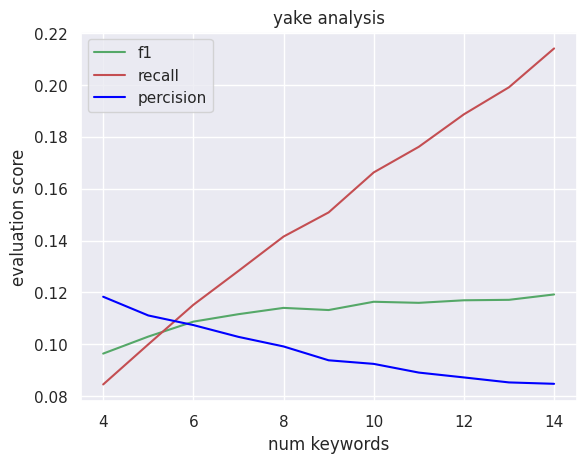

In [350]:
import seaborn as sns
sns.set_theme()

fig , axes = plt.subplots()

axes.set_title('yake analysis')
axes.set_xlabel('num keywords')
axes.set_ylabel('evaluation score')
axes.plot(num_keys, f1_scores,label = 'f1', color='g')
axes.plot(num_keys, recall_scores, label='recall', color='r')
axes.plot(num_keys, percision_scores, label='percision', color='blue')

axes.legend()

In [366]:
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = stopwords_list() + ['ها', 'های', 'ی']

vectorizer = TfidfVectorizer(ngram_range=(1, 4), min_df=0.01, tokenizer=word_tokenize, stop_words=stopwords, analyzer='word')

In [367]:
def tfidf_extractor(texts, top):
  candids = []
  for text in texts:
    X = vectorizer.fit_transform([text])

    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.toarray().sum(axis=0)

    top_keywords = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)[:top]
    keyword, score = zip(*top_keywords)
    candids.append(list(keyword))
  return candids

In [359]:
# with_chunking = preprocess(stemming=True, lemmatizing=False, reg_clean=True, tagging=True, remove_stopwords=True)
without_chunking = preprocess(stemming=True, lemmatizing=False, reg_clean=True, tagging=False, remove_stopwords=True)

In [368]:
# candids_chunking = tfidf_extractor(with_chunking, 10)
candids_without_chunking = tfidf_extractor(without_chunking, 10)

tfidf_score1 = []
tfidf_score2 = []

for i in range(len(candids_chunking)):
  # tfidf_score1.append(evaluate(candids_chunking[i], df.keywords.iloc[i]))
  tfidf_score2.append(evaluate(candids_without_chunking[i], df.keywords.iloc[i]))

# print(f'tfidf f1 score: with chunking  ', np.array(tfidf_score1).mean(axis=0)[0])
print(f'tfidf f1 score: without chunking  ', np.array(tfidf_score2).mean(axis=0)[0])

tfidf f1 score: without chunking   0.15415547027899532


In [361]:
num_keys = []
f1_scores = []
recall_scores = []
percision_scores = []

for k in range(4, 15):
  tfidf_score = []
  num_keys.append(k)
  candids = tfidf_extractor(with_chunking, k)
  for i in range(len(candids)):
    tfidf_score.append(evaluate(candids[i], df.keywords.iloc[i]))

  s = np.array(tfidf_score).mean(axis=0)
  f1_scores.append(s[0])
  recall_scores.append(s[1])
  percision_scores.append(s[2])

  print(f'tfidf f1 score: with {k} keyword ', np.array(tfidf_score).mean(axis=0)[0])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


tfidf f1 score: with 4 keyword  0.11891757987836406
tfidf f1 score: with 5 keyword  0.12999094958922797
tfidf f1 score: with 6 keyword  0.14660167046957556
tfidf f1 score: with 7 keyword  0.15338007457378905
tfidf f1 score: with 8 keyword  0.15641725749310897
tfidf f1 score: with 9 keyword  0.1610927730231809
tfidf f1 score: with 10 keyword  0.16240923476547398
tfidf f1 score: with 11 keyword  0.15995900456497028
tfidf f1 score: with 12 keyword  0.1603602049424864
tfidf f1 score: with 13 keyword  0.16113159735293978
tfidf f1 score: with 14 keyword  0.1591455350129678


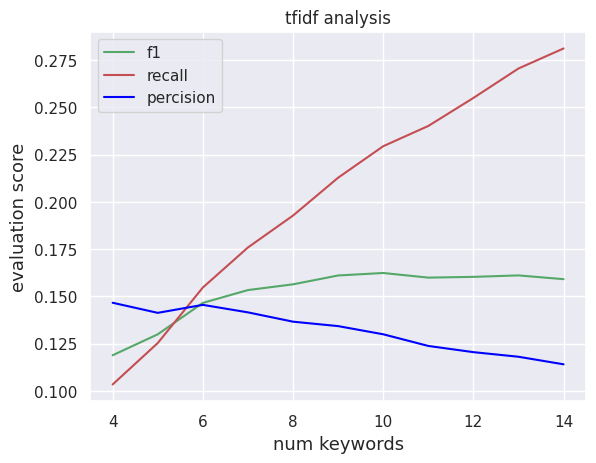

In [362]:
fig , axes = plt.subplots()

axes.set_title('tfidf analysis')
axes.set_xlabel('num keywords', fontsize=13)
axes.set_ylabel('evaluation score', fontsize=13)
axes.plot(num_keys, f1_scores, label = 'f1', color='g')
axes.plot(num_keys, recall_scores, label='recall', color='r')
axes.plot(num_keys, percision_scores, label='percision', color='blue')

axes.legend()